In [214]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm

In [224]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: [64, 7, 7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_size)
        self.logvar = nn.Linear(128, latent_size)

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return  z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: [32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [1, 28, 28]
            nn.Sigmoid()
        )
    
    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)
    
    def forward(self, z):
        return self.decode(z)

class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
    
    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        return self.decoder(z), mu, logvar
    
      
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [225]:
# Training the VAE
latent_dim = 2
beta = 1.0
vae = VAE(latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# DataLoader for MNIST
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# classes to use 
classes = [0, 1]

# Filter the dataset to only include the selected classes
indices = [i for i, label in enumerate(train_data.targets) if label in classes]
filtered_train_data = Subset(train_data, indices)

train_loader = DataLoader(filtered_train_data, batch_size=128, shuffle=True, drop_last=True)

# Training loop
vae.train()
epochs = 10
losses = []
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        # x_viewed = x.view(-1, 28 * 28) 
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = loss_function(x_recon, x, mu, logvar, beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss/len(train_data))
    print(f"Epoch {epoch + 1}, Loss: {total_loss/len(train_data):.2f}")

Epoch 1, Loss: 49.12
Epoch 2, Loss: 28.08
Epoch 3, Loss: 24.58
Epoch 4, Loss: 23.35
Epoch 5, Loss: 22.64
Epoch 6, Loss: 22.20
Epoch 7, Loss: 21.90
Epoch 8, Loss: 21.76
Epoch 9, Loss: 21.64
Epoch 10, Loss: 21.50


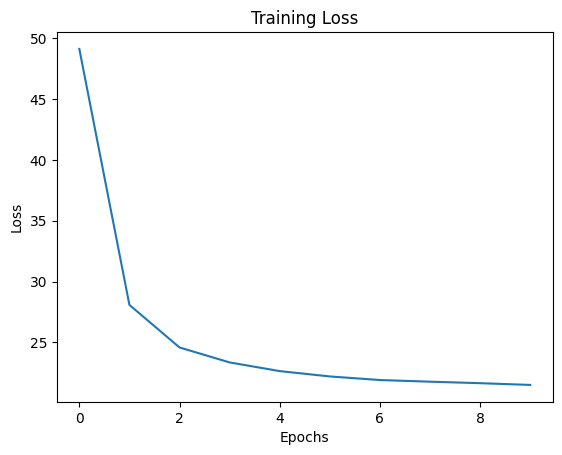

In [226]:
# Save the model
torch.save(vae.state_dict(), './models/vae_1_latent_dim_2_classes_0_1.pth')

# Plot the loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
# Used trained model
# vae.load_state_dict(torch.load('./models/vae_1_latent_dim_16.pth'))
# Visualizing the latent space
vae.eval()
latents, labels, var = [], [], []
with torch.no_grad():
    for x, y in train_loader:
        _, mu, logvar = vae(x)
        latents.append(mu)
        labels.append(y)
        var.append(torch.exp(0.5 * logvar))
latents = torch.cat(latents)
labels = torch.cat(labels)
var = torch.cat(var)

if latent_dim > 2:
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    latents_tsne = tsne.fit_transform(latents)

torch.Size([12544, 2])


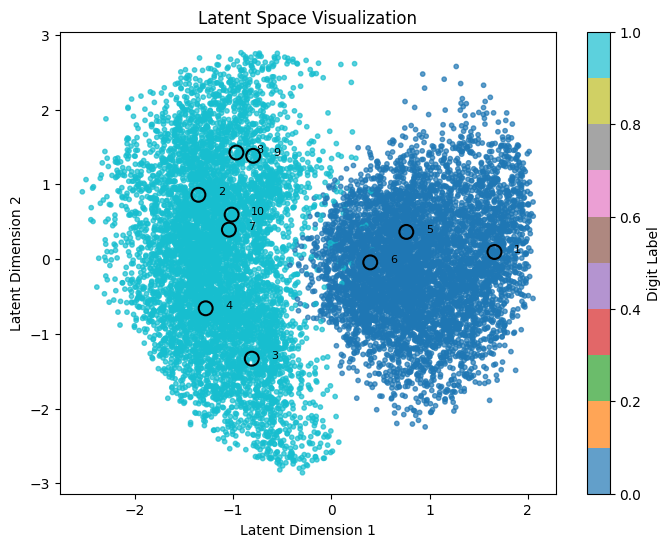

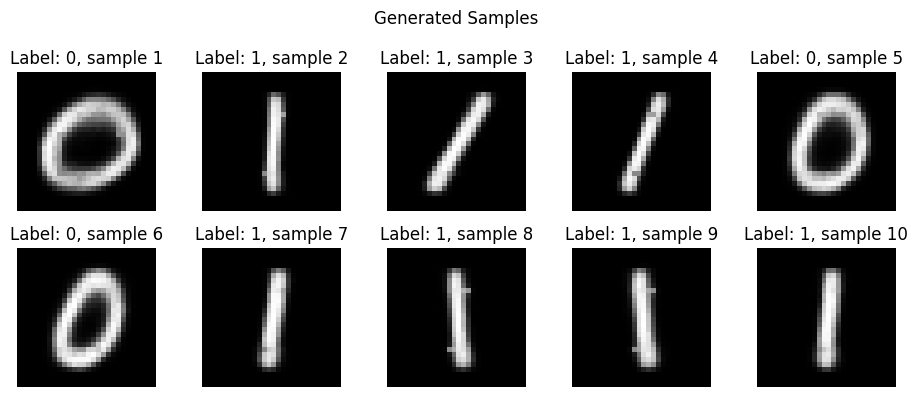

In [228]:
decoder = vae.decoder
n_samples = 10
sample_indices = torch.randint(0, len(latents), (n_samples,))
sample_latents = torch.Tensor(latents[sample_indices])
sample_labels = labels[sample_indices]
with torch.no_grad():
    generated = decoder(sample_latents)
    generated = generated.view(-1, 28, 28).numpy()
cmap_binary = matplotlib.colors.ListedColormap(['blue', 'red'])
# Projection on the 2D latent space or if latent_dim = 2, plot the latent space
if latent_dim > 2:
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], c=labels, cmap=cmap_binary, alpha=0.7, s=10)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization of Latent Space')
else :
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')

# Entourer les points échantillonnés
if latent_dim > 2:
    for idx, (x, y) in enumerate(latents_tsne[sample_indices]):
        plt.scatter(x, y, edgecolor='black', facecolor='none', s=100, linewidth=1.5) 
        plt.text(x + 2, y, f'{idx+1}', color='black', fontsize=8) 
else:
    for idx, (x, y) in enumerate(sample_latents[:, :2]):
        plt.scatter(x, y, edgecolor='black', facecolor='none', s=100, linewidth=1.5)  # Cercle rouge
        plt.text(x + 0.2, y, f'{idx+1}', color='black', fontsize=8)  # Annoter avec un index

plt.show()

plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'Label: {sample_labels[i].item()}, sample {i + 1}')
    plt.suptitle('Generated Samples')
plt.show()

### ENSURING PROPER GEOMETRY THROUGH MEANINGFUL VARIANCE FUNCTIONS

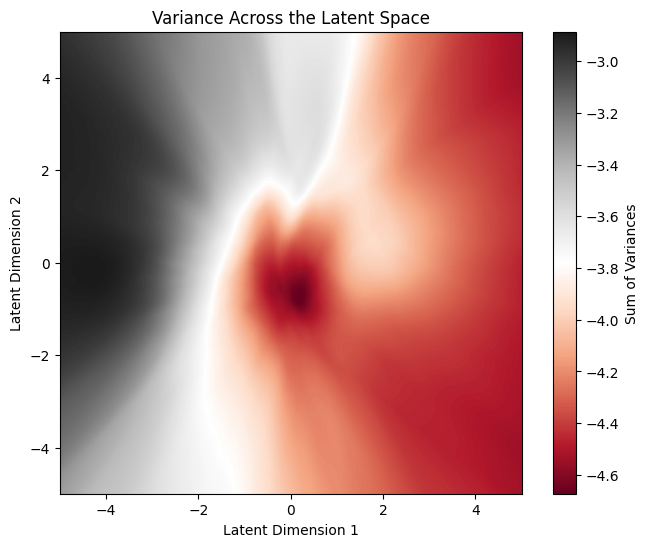

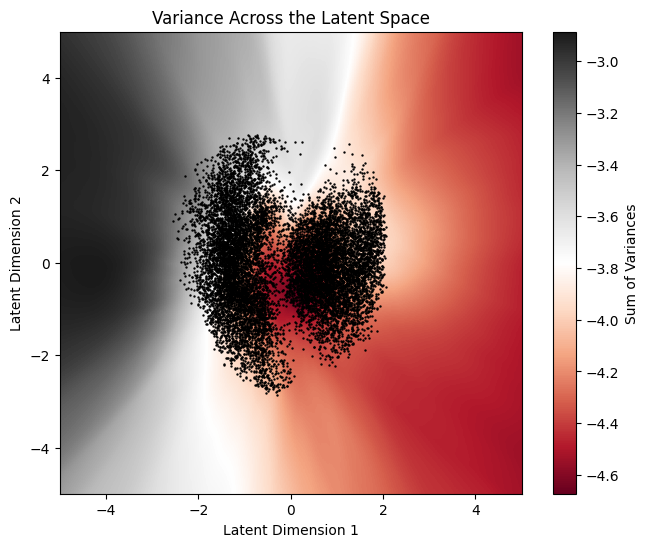

In [230]:
# t-SNE of the variance
if latent_dim == 2:
    
    grid_range = 5  # Cover latent space in [-3, 3] for each dimension
    grid_resolution = 200  # Number of points per axis

    # Generate a grid of points in the latent space
    x = np.linspace(-grid_range, grid_range, grid_resolution)
    y = np.linspace(-grid_range, grid_range, grid_resolution)
    grid_x, grid_y = np.meshgrid(x, y)
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)  # Shape: (grid_resolution^2, 2)

    # Convert grid points to a tensor
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)

    # Pass grid points through the decoder to reconstruct data
    vae.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        reconstructed_data = vae.decoder(grid_points_tensor)  # Shape: (grid_resolution^2, input_dim)

    # Pass the reconstructed data through the encoder to compute mu and logvar
    with torch.no_grad():
        _, mu, logvar = vae.encoder(reconstructed_data)  # Encoder maps reconstructed data back to latent space
        variance = torch.exp(logvar)  # Convert logvar to variance

    # Compute the sum of variances across latent dimensions
    variance_sum = variance.sum(dim=-1).numpy()

    # Reshape variance_sum to match the grid shape
    variance_sum_grid = variance_sum.reshape(grid_resolution, grid_resolution)

    # Plot the variance as a heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(
        np.log(variance_sum_grid),
        extent=[-grid_range, grid_range, -grid_range, grid_range],
        origin='lower',
        cmap='RdGy',
    )
    plt.colorbar(label='Sum of Variances')

    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Variance Across the Latent Space')
    plt.show()
    # Plot the variance as a heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(
        np.log(variance_sum_grid),
        extent=[-grid_range, grid_range, -grid_range, grid_range],
        origin='lower',
        cmap='RdGy',
    )
    plt.colorbar(label='Sum of Variances')

    plt.scatter(latents[:, 0], latents[:, 1], c='black', s=0.5, label='Training Data')

    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Variance Across the Latent Space')
    plt.show()
else:
    
     # Compute log(sum_j(sigma_j(z))) for color mapping
    summed_var = [torch.sum(v).item() for v in var]  # Summing variances
    log_summed_var = torch.log(torch.tensor(summed_var))  # Logarithm of summed variances

    # Plot t-SNE visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        latents_tsne[:, 0], latents_tsne[:, 1], 
        c=log_summed_var, cmap='RdGy', alpha=0.7, s=10
    )
    plt.colorbar(scatter, label='Log(Sum of Variances)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization of Latent Space with Variance Color Map')
    plt.show()

The variance far from the data (in black) are pretty arbitrary values

Now, we will use an external network that will learn the variance sigma in order to set it far from the data. This will make it easier all the geometry onto the latent space

In [231]:
class RBFNetwork(nn.Module):
    def __init__(self, centers, bandwidths, latent_dim):
        super(RBFNetwork, self).__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32), requires_grad=False)  # Fixed centers
        self.bandwidths = nn.Parameter(torch.tensor(bandwidths, dtype=torch.float32), requires_grad=False)  # Fixed bandwidths
        self.weights = nn.Parameter(torch.ones(centers.shape[0], latent_dim))  # Learnable weights
        self.epsilon = 1e-6  # Small constant to avoid division by zero

    def forward(self, z):
        # Compute RBF activations
        distances = torch.cdist(z, self.centers) ** 2  # Squared distances
        activations = torch.exp(-self.bandwidths.unsqueeze(0) * distances)
        
        # Compute precision
        precision = activations @ self.weights + self.epsilon
        return 1 / precision  # Convert precision to variance


In [232]:
from sklearn.cluster import KMeans
# Encode training data to latent space
vae.eval()
z_train, sigma2_train = [], []
with torch.no_grad():
    for x, _ in train_loader:
        _, mu, logvar = vae.encoder(x)
        z_train.append(mu)
        sigma2_train.append(torch.exp(logvar))

z_train = torch.cat(z_train).numpy()  # Latent representations
sigma2_train = torch.cat(sigma2_train).numpy()  # Variance estimates

# Perform k-means to find RBF centers
K = 32  # Number of RBF centers used in the paper
kmeans = KMeans(n_clusters=K, random_state=0).fit(z_train)
centers = kmeans.cluster_centers_  # RBF centers
labels = kmeans.labels_

# Compute bandwidths
a = 1.0  # Hyperparameter for RBF sharpness used in the paper
bandwidths = []
for k in range(K):
    cluster_points = z_train[labels == k]
    if len(cluster_points) > 0:
        bandwidth = 0.5* (a / len(cluster_points) * np.sum(np.linalg.norm(cluster_points - centers[k], axis=1)))**-2
    else:
        bandwidth = 1.0  # Fallback for empty clusters
    bandwidths.append(bandwidth)

bandwidths = np.array(bandwidths)

# Initialize the RBF network
latent_dim = z_train.shape[1]
rbf_net = RBFNetwork(centers, bandwidths, latent_dim)

# Train the RBF network
optimizer = torch.optim.Adam(rbf_net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

z_train_tensor = torch.tensor(z_train, dtype=torch.float32)
sigma2_train_tensor = torch.tensor(sigma2_train, dtype=torch.float32)

for epoch in range(1001):  # Training loop
    optimizer.zero_grad()
    predicted_variance = rbf_net(z_train_tensor)
    loss = criterion(predicted_variance, sigma2_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 28.784406661987305
Epoch 100, Loss: 23.993715286254883
Epoch 200, Loss: 20.683591842651367
Epoch 300, Loss: 18.247495651245117
Epoch 400, Loss: 16.367578506469727
Epoch 500, Loss: 14.865568161010742
Epoch 600, Loss: 13.633133888244629
Epoch 700, Loss: 12.600378036499023
Epoch 800, Loss: 11.720069885253906
Epoch 900, Loss: 10.959035873413086
Epoch 1000, Loss: 10.293254852294922


torch.Size([40000, 2])


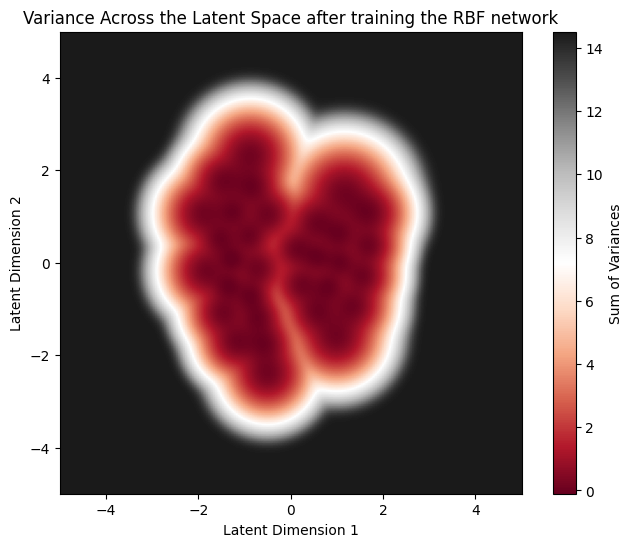

In [233]:
grid_range = 5  # Cover latent space in [-3, 3] for each dimension
grid_resolution = 200  # Number of points per axis

# Generate a grid of points in the latent space
x = np.linspace(-grid_range, grid_range, grid_resolution)
y = np.linspace(-grid_range, grid_range, grid_resolution)
grid_x, grid_y = np.meshgrid(x, y)
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)  # Shape: (grid_resolution^2, 2)

# Convert grid points to a tensor
grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
print(grid_points_tensor.shape)
# Pass grid points through the RBF network to compute variance
with torch.no_grad():
    predicted_variance = rbf_net(grid_points_tensor).numpy()

predicted_variance_sum = np.sum(predicted_variance, axis=-1)
# Reshape predicted_variance to match the grid shape
predicted_variance_sum_grid = predicted_variance_sum.reshape(grid_resolution, grid_resolution)

# Plot the variance as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(
    np.log(predicted_variance_sum_grid),
    extent=[-grid_range, grid_range, -grid_range, grid_range],
    origin='lower',
    cmap='RdGy',
)
plt.colorbar(label='Sum of Variances')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Variance Across the Latent Space after training the RBF network')
plt.show()

#### Let us add this trained network to the main VAE (Optional for the moment)

In [ ]:
class Encoder_RBF(nn.Module):
    def __init__(self, latent_size, RBF_Network):
        super(Encoder_RBF, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: [32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: [64, 7, 7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_size)
        self.RBF_Network = RBF_Network

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        with torch.no_grad():
            var = self.RBF_Network(mu)
        return mu, var

    def reparameterize(self, mu, var):
        std = torch.sqrt(var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        return  z, mu, var
    
class VAE_RBF(nn.Module):
    def __init__(self, latent_size, RBF_Network):
        super(VAE_RBF, self).__init__()
        self.encoder = Encoder_RBF(latent_size, RBF_Network)
        self.decoder = Decoder(latent_size)
    
    def forward(self, x):
        z, mu, var = self.encoder(x)
        return self.decoder(z), mu, var
    
def loss_function_vae_rbf(recon_x, x, mu, var, beta=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * beta * torch.sum(1 + torch.log(var) - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
vae_rbf = VAE_RBF(latent_dim, rbf_net)

# Training the VAE with RBF
vae_rbf.train()
optimizer = optim.Adam(vae_rbf.parameters(), lr=1e-3)

epochs = 10
losses = []
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        # x_viewed = x.view(-1, 28 * 28) 
        optimizer.zero_grad()
        x_recon, mu, var = vae_rbf(x)
        print(var)
        loss = loss_function_vae_rbf(x_recon, x, mu, var, beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss/len(train_data))
    print(f"Epoch {epoch + 1}, Loss: {total_loss/len(train_data):.2f}")

tensor([[2.9735, 2.9735],
        [3.0101, 3.0100],
        [3.0260, 3.0260],
        [3.2571, 3.2571],
        [3.3448, 3.3448],
        [3.2959, 3.2959],
        [3.2119, 3.2119],
        [3.2030, 3.2030],
        [3.1938, 3.1937],
        [3.2235, 3.2235],
        [3.2002, 3.2002],
        [3.2982, 3.2981],
        [3.3672, 3.3672],
        [3.2810, 3.2810],
        [3.3258, 3.3258],
        [3.0084, 3.0084],
        [3.3664, 3.3663],
        [3.2580, 3.2579],
        [3.2695, 3.2694],
        [2.9255, 2.9255],
        [2.8319, 2.8318],
        [3.1420, 3.1419],
        [3.2772, 3.2772],
        [2.9060, 2.9060],
        [2.8863, 2.8863],
        [2.9558, 2.9557],
        [3.2033, 3.2033],
        [3.2036, 3.2036],
        [3.1147, 3.1147],
        [2.8723, 2.8723],
        [3.2408, 3.2408],
        [3.1514, 3.1513],
        [3.1512, 3.1512],
        [3.1996, 3.1996],
        [3.0764, 3.0764],
        [2.9743, 2.9743],
        [3.2890, 3.2890],
        [3.1889, 3.1889],
        [3.3

KeyboardInterrupt: 

#### Let us work on our new space 

In [ ]:
# # Define resolution of the mesh in 2D space (t-SNE space)
# resolution = 30  # You can adjust this to control the density of the grid
# latents_tsne = torch.tensor(latents_tsne)
# min_vals = latents_tsne.min(dim=0).values
# max_vals = latents_tsne.max(dim=0).values

# # Generate mesh grid in the t-SNE space
# x_range = torch.linspace(min_vals[0], max_vals[0], resolution)
# y_range = torch.linspace(min_vals[1], max_vals[1], resolution)

# # Create 2D grid using meshgrid
# xx, yy = torch.meshgrid(x_range, y_range)

# # Reshape into list of 2D points
# mesh_2d = torch.stack([xx.flatten(), yy.flatten()], dim=-1)

# from sklearn.neighbors import NearestNeighbors

# # Fit a nearest neighbor model on the original latent space (latents_2d in this case)
# knn = NearestNeighbors(n_neighbors=1)
# knn.fit(latents_tsne)  # latents_2d is the 2D projection of the latent space

# # Find the closest latent points in the high-dimensional space for each point in the 2D mesh
# _, indices = knn.kneighbors(mesh_2d.numpy())  # Convert mesh_2d to numpy for sklearn compatibility

# # Get the corresponding latent vectors from latents (high-dimensional space)
# mapped_latents = latents[indices.flatten()]

# def compute_distortion(z, decoder):
#     """
#     Computes the square root of det(J^T J) for a given latent point z.
    
#     Args:
#         z (torch.Tensor): Latent point of shape (latent_dim,).
#         decoder (callable): Decoder function.
    
#     Returns:
#         float: The distortion measure sqrt(det(J^T J)).
#     """
#     latent_dim = z.shape[0]
#     z = z.unsqueeze(0).requires_grad_(True)  # Ensure gradients are enabled for z
#     J = torch.autograd.functional.jacobian(lambda x: decoder(x), z)  # Compute Jacobian
#     J = J.squeeze(0).squeeze(2).reshape(-1, latent_dim)# Remove batch dimension
#     J_T_J = torch.matmul(J.T, J)  # Compute J^T J
#     det_J_T_J = torch.linalg.det(J_T_J)
#     if det_J_T_J < 0:  # Handle numerical instabilities
#         return 0
#     return torch.sqrt(det_J_T_J).item()  # Return sqrt(det(J^T J))


# distortions = []
# for z in tqdm(mapped_latents):
#     distortions.append(compute_distortion(z, vae.decoder))  # Compute distortion for each latent point

# distortions = torch.tensor(distortions)

# from scipy.ndimage import gaussian_filter

# distortions_norm = (distortions - distortions.min()) / (distortions.max() - distortions.min())
# log_distortions = np.log1p(distortions)
# smoothed_distortions = gaussian_filter(distortions_norm, sigma=2)
# distortions_list = [distortions, distortions_norm, log_distortions, smoothed_distortions]

# from scipy.interpolate import griddata

# for distortions_transform in distortions_list:
#     distortion_grid = griddata(mesh_2d.numpy(), distortions_transform, (xx, yy.numpy()), method='nearest')
#     plt.figure(figsize=(8, 6))
#     plt.imshow(distortion_grid, extent=[min_vals[0], max_vals[0], min_vals[1], max_vals[1]], origin='lower', cmap='viridis')
#     plt.colorbar(label='sqrt(det(J^T J))')
#     plt.title('Distortion map in Latent Space')
#     plt.xlabel('Latent Dimension 1 (projected)')
#     plt.ylabel('Latent Dimension 2 (projected)')
#     plt.show()

Go from 2D (t-SNE) observation space to the real latent space

In [ ]:
def compute_jacobian_mu_sigma(vae, x):
    """
    Compute the Jacobian matrices for mu and sigma with respect to the latent space.

    Args:
        vae: Trained VAE model
        x: Input batch of data
        latent_dim: Dimensionality of the latent space

    Returns:
        J_mu, J_sigma: Jacobians of mu and sigma
    """
    # Get mu and log_var from the encoder
    x = x.requires_grad_(True)  # Enable gradients for input

    # Initialize Jacobians
    batch_size = x.shape[0]
    J_mu = []
    J_sigma = []
    for i in range(batch_size):
        x_i = x[i:i+1]  # Select one sample
        J_mu_i = torch.autograd.functional.jacobian(lambda x: vae.encoder(x)[1], x_i)
        J_mu.append(J_mu_i)

        J_sigma_i = torch.autograd.functional.jacobian(lambda x: torch.exp(0.5*vae.encoder(x)[2]), x_i)
        J_sigma.append(J_sigma_i)
    
    J_mu = torch.stack(J_mu, dim=0)
    J_sigma = torch.stack(J_sigma, dim=0)

    # Reshape
    J_mu = J_mu.squeeze(1).squeeze(2).squeeze(2)
    J_sigma = J_sigma.squeeze(1).squeeze(2).squeeze(2)
    return J_mu, J_sigma

# Compute Jacobians for a batch of data
# Visualizing the latent space
vae.eval()
distortion = []
with torch.no_grad():
    for x, _ in tqdm(train_loader):
        J_mu, J_sigma = compute_jacobian_mu_sigma(vae, x)
#         distortion.append(compute_distortion(J_mu, J_sigma))
# distortion = torch.cat(distortion)



100%|██████████| 98/98 [01:28<00:00,  1.10it/s]


In [ ]:
def compute_distortion(J_mu, J_sigma):
    """
    Compute the distortion measure based on the Jacobians J_mu and J_sigma.

    Args:
        J_mu: Jacobian of mu
        J_sigma: Jacobian of sigma

    Returns:
        distortion: Distortion measure
    """
    # Compute J^T * J
    JTJ_mu = torch.matmul(J_mu.transpose(-1, -2), J_mu)
    JTJ_sigma = torch.matmul(J_sigma.transpose(-1, -2), J_sigma)
    # print(JTJ_mu)
    # print(JTJ_sigma)
    J_composed = JTJ_mu + JTJ_sigma
    print(J_composed.shape)
    print(J_composed)
    # Compute determinant
    det_JTJ = torch.det(J_composed)
    print(det_JTJ.shape)
    # Take square root to get distortion measure
    distortion = torch.sqrt(torch.abs(det_JTJ))
    print(distortion.shape)
    return distortion
dist_mu = compute_distortion(J_mu, J_sigma)
print(dist_mu)

torch.Size([128, 4, 28, 28])
tensor([[[[ 2.7160e-03,  5.2239e-03,  1.9932e-03,  ...,  4.2692e-04,
            4.1487e-04,  4.6898e-04],
          [ 5.2239e-03,  1.1796e-02,  3.7187e-03,  ...,  1.6244e-04,
            6.3558e-04,  1.0384e-03],
          [ 1.9932e-03,  3.7187e-03,  4.1822e-03,  ...,  2.8446e-03,
            1.1666e-03,  9.9480e-04],
          ...,
          [ 4.2692e-04,  1.6244e-04,  2.8446e-03,  ...,  5.4750e-03,
            1.9469e-03,  9.0838e-04],
          [ 4.1487e-04,  6.3558e-04,  1.1666e-03,  ...,  1.9469e-03,
            1.0137e-03,  4.9712e-04],
          [ 4.6898e-04,  1.0384e-03,  9.9480e-04,  ...,  9.0838e-04,
            4.9712e-04,  6.9492e-04]],

         [[ 2.1140e-03,  4.2152e-03,  7.0904e-04,  ..., -1.2295e-04,
            5.1719e-04,  2.8337e-04],
          [ 4.2152e-03,  1.3447e-02, -1.1399e-03,  ...,  5.0382e-04,
            1.3648e-03,  1.9430e-03],
          [ 7.0904e-04, -1.1399e-03,  3.1264e-03,  ..., -1.9441e-03,
           -3.5679e-04, -7.21

ValueError: 'c' argument has 960000 elements, which is inconsistent with 'x' and 'y' with size 60000.

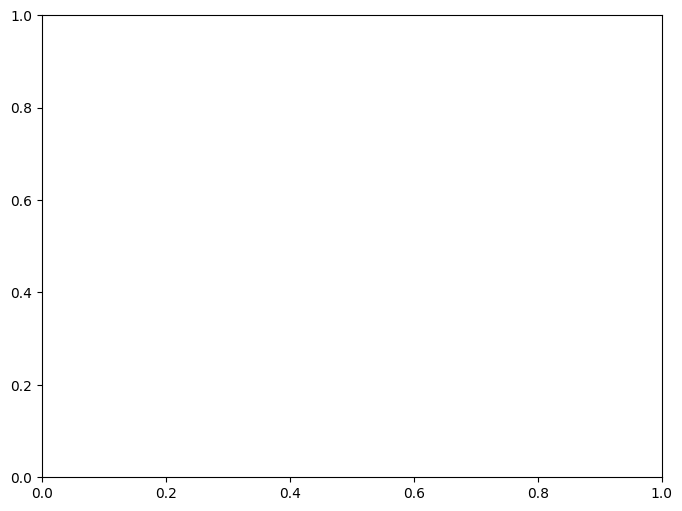

In [ ]:
# Visualize distortions in t-SNE space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], c=distortion, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Distortion (sqrt(det(J^T J)))')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization with Distortion')
plt.show()